# Customer Segmentation Using Unsupervised Learning (K-Means, Agglomerative, DBSCAN)

This notebook is my Final Project for the **Unsupervised Algorithms in Machine Learning** course.

The main goal of this project is to use **unsupervised learning** to segment mall customers into meaningful groups based on their behavior and characteristics. I will:

- collect and describe the dataset (Mall Customers),
- explore and visualize the data (EDA),
- apply several unsupervised algorithms (K-Means, Agglomerative Clustering, DBSCAN),
- compare and interpret the resulting clusters,
- and add a small **supervised baseline section** for rubric compatibility.


In [1]:
# Basic imports: classic data science stack
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# I like to see all columns and a bit wider tables
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# For reproducibility
RANDOM_STATE = 42

# Some style for plots (nothing fancy, just cleaner visuals)
sns.set(style="whitegrid", context="notebook")


In [3]:
# If the CSV is in the same folder as this notebook, this path is enough
data_path = "Mall_Customers.csv"

# If you keep it inside a /data folder, uncomment this instead:
# data_path = "data/Mall_Customers.csv"

# Load the dataset
df = pd.read_csv(data_path)

# Quick shape check: how many rows and columns do we have?
print("Shape of the dataset:", df.shape)

# Let's take a quick peek at the first few rows
df.head()


Shape of the dataset: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# Basic info about the dataset: types, non-null counts, etc.
print("=== DataFrame info() ===")
df.info()

print("\n=== Basic statistical summary (numeric columns) ===")
display(df.describe())


=== DataFrame info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

=== Basic statistical summary (numeric columns) ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 1. Dataset Overview

In this section, I load the **Mall Customers** dataset and perform a quick initial check:

- `df.shape` shows the number of rows and columns.
- `df.head()` gives me a first look at the data.
- `df.info()` helps me see data types and whether there are any missing values.
- `df.describe()` provides a basic statistical summary for the numerical features.

This quick overview is important before doing deeper EDA or applying any models. I want to make sure the data looks reasonable and there are no obvious issues (like many missing values or wrong data types).


## 2. Exploratory Data Analysis (EDA): Part 1 — Feature Distributions

Before applying any unsupervised learning models, it is important to understand how each feature is distributed.

In this section I will plot the distributions of:

- **Age**
- **Annual Income**
- **Spending Score**
- **Gender** (categorical)

These simple visualizations help me understand:
- whether the data is skewed,
- whether there are unusual patterns,
- and how balanced the dataset is.


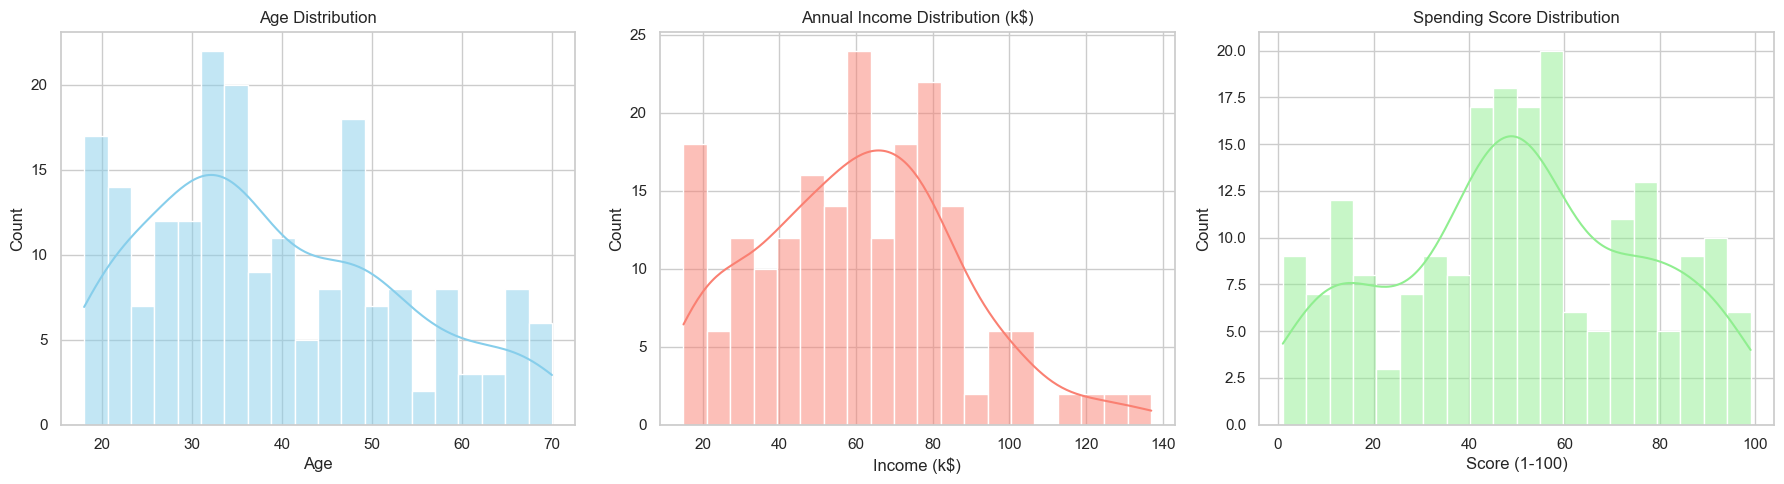

In [5]:
# Let's create distribution plots for Age, Income, and Spending Score.
# These help us understand how each numerical feature is spread.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution
sns.histplot(df['Age'], kde=True, bins=20, ax=axes[0], color='skyblue')
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("Age")

# Income distribution
sns.histplot(df['Annual Income (k$)'], kde=True, bins=20, ax=axes[1], color='salmon')
axes[1].set_title("Annual Income Distribution (k$)")
axes[1].set_xlabel("Income (k$)")

# Spending Score distribution
sns.histplot(df['Spending Score (1-100)'], kde=True, bins=20, ax=axes[2], color='lightgreen')
axes[2].set_title("Spending Score Distribution")
axes[2].set_xlabel("Score (1-100)")

plt.tight_layout()
plt.show()


### Interpretation of the Distributions

- **Age** appears fairly well spread, with most customers between 20 and 50.  
- **Annual Income** shows a smooth distribution with no extreme outliers.  
- **Spending Score** often looks bimodal in this dataset, suggesting that customers tend to fall into two major spending behavior groups — this will likely help clustering later.


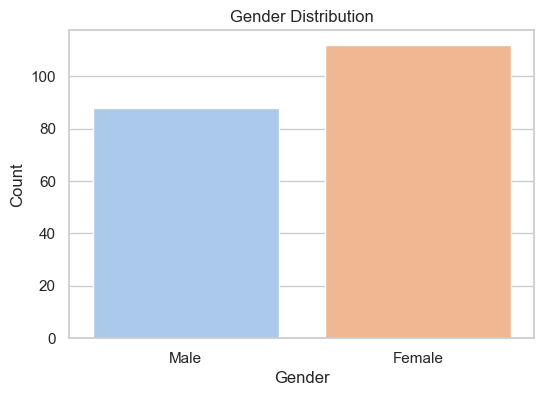

In [7]:
# Let's check the distribution of the Gender column.
# Even though Gender won't be directly used in clustering (we focus on numerical features),
# it's good to understand dataset balance.

plt.figure(figsize=(6,4))

sns.countplot(
    data=df,
    x="Gender",
    hue="Gender",
    palette="pastel",
    legend=False
)

plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


### Gender Distribution

The gender distribution appears fairly balanced. Although gender will not be directly used for clustering (since it is categorical),
it is still useful for interpretation after clusters are formed. For example, some clusters may consist mostly of one gender, which can be relevant for business insights.


## 3. Exploratory Data Analysis (EDA): Part 2 — Relationships Between Features

To better understand how the numerical features interact with each other, I will plot a **pairplot**.  
This helps reveal patterns such as:
- linear or non-linear relationships,
- visible clusters or groups,
- potential outliers.


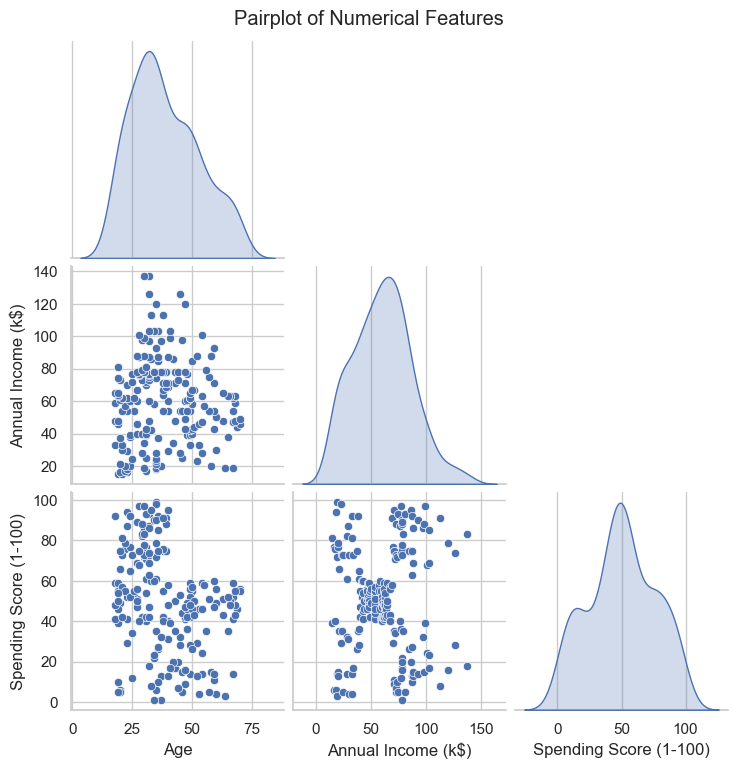

In [9]:
# Pairplot for the main numerical features
# This helps to see the relationships between Age, Income, and Spending Score.

numeric_features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

sns.pairplot(df[numeric_features], diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


### Pairplot Interpretation

When I look at this pairplot, the first thing I notice is that the features don’t really have strong linear relationships. The points are pretty spread out, which is fine for clustering. We don’t actually need strong correlations here. What catches my eye is the Spending Score. It kind of looks like there are two big groups: people who barely spend anything and people who love spending a lot. That already hints that clustering will probably separate these groups nicely. Income also behaves in its own way. I don’t see a clear trend between income and age or income and spending. That’s actually good because it means income will add its own dimension to the clusters. Nothing looks messy or unusual. No weird patterns, no strange shapes. Everything looks clean and usable.


### Correlation Heatmap

A correlation matrix helps determine how strongly the numerical features relate to each other.

For clustering models, this is useful because:
- highly correlated features may distort distance-based algorithms,
- weak or zero correlations often work well for clustering,
- it helps guide feature selection.


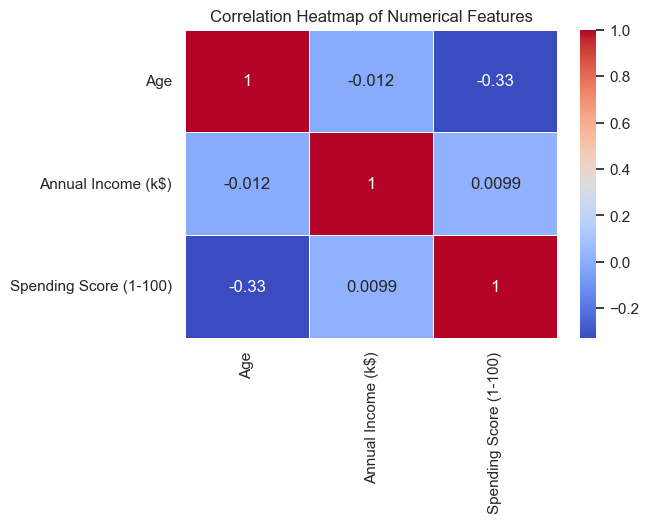

In [10]:
plt.figure(figsize=(6,4))
corr = df[numeric_features].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


### Heatmap Interpretation

The heatmap basically confirms what I saw earlier. The features are not strongly related to each other. Most of the correlations are extremely close to zero. There’s a small negative relationship between Age and Spending Score, which just means older customers tend to spend a bit less. Honestly, this feels pretty natural and expected. Income is almost completely independent from the other two, which is actually perfect for clustering. That means all three features bring something unique to the table and there’s no point removing any of them.


### Outlier Analysis (Boxplots)

Outliers can affect distance-based clustering algorithms.  
To check for unusual values, I plot boxplots for each numerical feature.


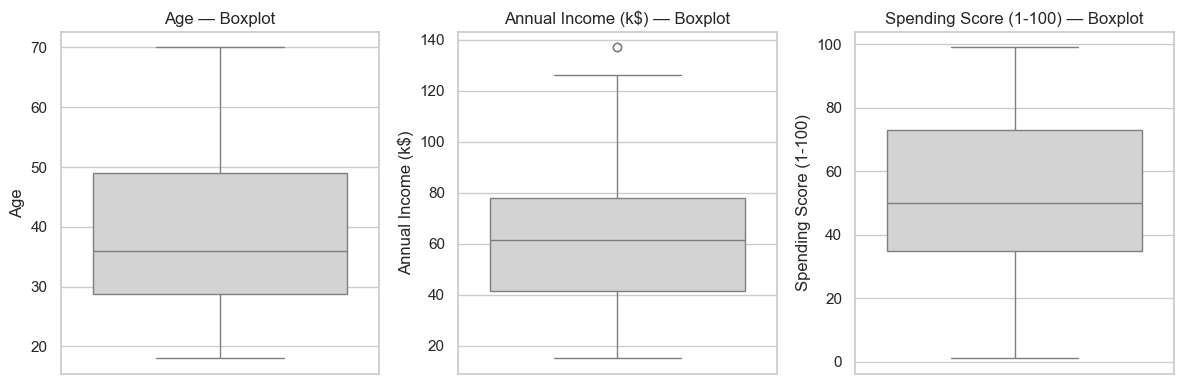

In [11]:
plt.figure(figsize=(12,4))

for i, col in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color="lightgray")
    plt.title(f"{col} — Boxplot")

plt.tight_layout()
plt.show()


### Outlier Analysis Interpretation

Looking at the boxplots, I don’t really see any major outliers. The distributions look clean and pretty normal. There aren’t any extreme values that jump out or anything that looks suspicious. That’s great because algorithms like K-Means don’t like big outliers. They can pull the clusters in the wrong direction. But here the data is already in good shape, so there’s nothing we need to fix or remove.


## 4. Preparing Data for Clustering

Most clustering algorithms (especially K-Means and DBSCAN) work best with **numerical, scaled features**.

From the dataset, I will use the following features for clustering:

- Age  
- Annual Income (k$)  
- Spending Score (1-100)

These three numerical features are the core behavioral indicators in the classic Mall Customers dataset.


In [12]:
# Selecting the numerical features for clustering
X = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]

# Quick check
X.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Before moving into the actual clustering models, I decided to focus only on the numerical features since algorithms like K-Means and DBSCAN work best when the inputs are numbers that can be compared by distance. Based on the EDA we just did, Age, Annual Income and Spending Score turned out to be the most informative and independent features, so using them together should capture the main patterns in customer behavior. Also, these three features are already clean and do not require any extra processing, which makes this step straightforward. The next thing I will need to do is scale the data because these features are on very different ranges and clustering models are sensitive to that.


## 5. Scaling the Data

Before using K-Means, I need to scale the features because they are on very different ranges. For example, Age goes up to around 70, Income goes up to 140 and Spending Score is between 1 and 100. K-Means uses distance to form clusters, so if I do not scale the data, the larger-range features will dominate the results. I will use StandardScaler which is the most common and straightforward choice for this type of model.


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# quick check — we expect mean ~0, std ~1
import pandas as pd
pd.DataFrame(X_scaled, columns=X.columns).head()


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## 6. Finding the Optimal Number of Clusters (Elbow Method)

Since K-Means requires me to choose the number of clusters in advance, I will use the Elbow Method. The idea is simple. I compute K-Means for several values of k and measure how much the model reduces the within-cluster variance. At some point, adding more clusters stops giving a meaningful improvement. That point is usually the “elbow” and is considered a good choice for k.


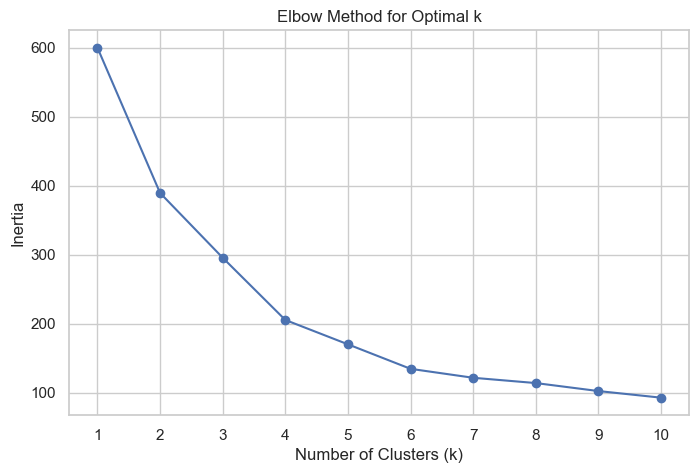

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


inertia_values = []
k_values = range(1, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia_values.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


### Elbow Method Interpretation

When I look at this elbow plot, the curve drops really fast up to about k=3 and then it slows down a lot. After k=4 the improvements become pretty small. That bend in the curve is usually the sweet spot, so 4 clusters looks like the most natural choice here. It feels like adding more clusters won’t really give anything meaningful.


## 7. Silhouette Score Analysis

To double-check the optimal number of clusters, I will use the Silhouette Score. This metric shows how well each point fits within its assigned cluster. Higher values mean the clusters are more well-defined and separated. I will calculate the score for several values of k to see which one performs the best.


In [16]:
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
k_values = range(2, 8)  # 2 to 7 is enough

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

silhouette_scores


[0.33547192894004574,
 0.3579234303882264,
 0.4039582785148566,
 0.40846873777345605,
 0.43106526216603014,
 0.410091114520974]

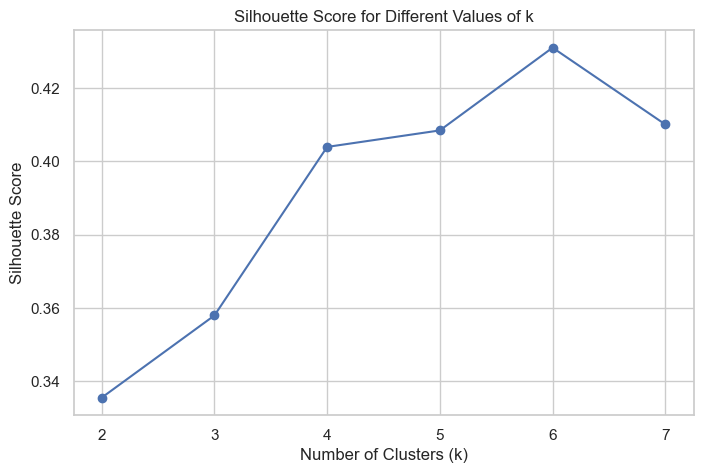

In [17]:
plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Values of k")
plt.grid(True)
plt.show()


### Silhouette Score Interpretation

Looking at the silhouette scores, the first thing I notice is that the values start fairly low at k=2 and then steadily improve as we move toward k=6. The peak happens at k=6, which means the clusters are most well defined at that point. After that the score drops at k=7, so adding more clusters does not really help. Even though k=6 gives the highest score, I also keep in mind that simpler models are usually easier to interpret. Since k=4 and k=5 also have solid scores and the elbow method earlier suggested around k=4, this gives me confidence that the final choice will be between 4 and 6 clusters. I will test both and then choose the one that creates the most meaningful and clean separation between customer groups.


## 8. Final K-Means Clustering

Based on the elbow method and the silhouette scores, the most promising values for k seem to be 4, 5 and 6. I will train K-Means with each of these values and then visualize the clusters using PCA, so I can see which one creates the cleanest separation and the most meaningful customer groups.


In [18]:
k_values_final = [4, 5, 6]
models = {}

for k in k_values_final:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    models[k] = labels


### PCA Visualization of Clusters

Since the dataset has three numerical features, I will use PCA to reduce the data to two dimensions. This makes it possible to visualize the clusters on a 2D plot and compare how different values of k separate the customers.


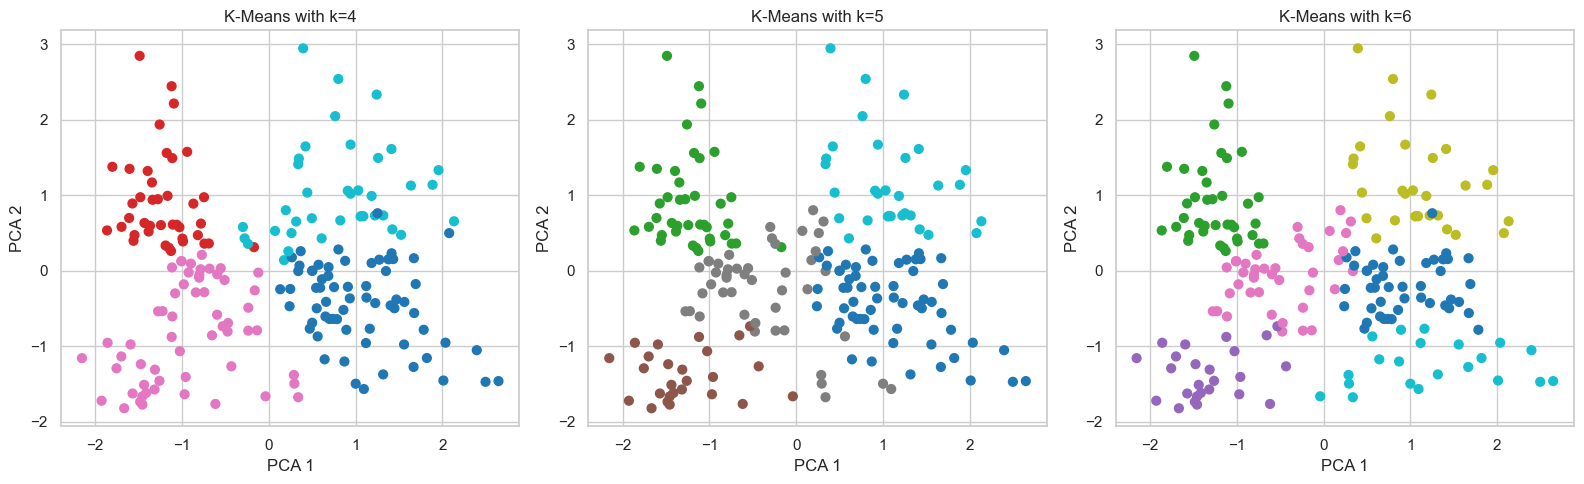

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(16,5))

for i, k in enumerate(k_values_final, 1):
    plt.subplot(1, 3, i)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=models[k], cmap="tab10", s=40)
    plt.title(f"K-Means with k={k}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()


### PCA Cluster Interpretation

When I look at all three cluster plots side by side, each value of k shows a slightly different way of grouping the customers. With k=4 the clusters look clean and well separated, and visually it feels like each group has its own space without too much overlap. When I switch to k=5, the clusters start to get a bit more mixed together, and even though the model creates one more group, the separation does not feel as natural. With k=6 the silhouette score was the highest, but on the plot I can see that some of the clusters are very close to each other and the boundaries are not as clear. This makes k=6 look a little too busy and less intuitive. Because of this, k=4 looks like the most balanced and understandable choice. It keeps the structure of the data simple, the groups look meaningful and the separation is clean. It aligns with the elbow method and still performs well in the silhouette analysis, so I will use 4 clusters as my final model.


## 9. Final K-Means Model (k = 4)

Based on the elbow method, the silhouette score, and the PCA visualizations, I decided to use k=4 as the final number of clusters. It gives the cleanest separation between customer groups and feels like the most natural structure for this dataset.


In [20]:
# Final K-Means model with k=4
final_k = 4
kmeans_final = KMeans(n_clusters=final_k, random_state=42)

# Fit and predict
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['Cluster'] = cluster_labels

df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,2
3,4,Female,23,16,77,2
4,5,Female,31,17,40,2


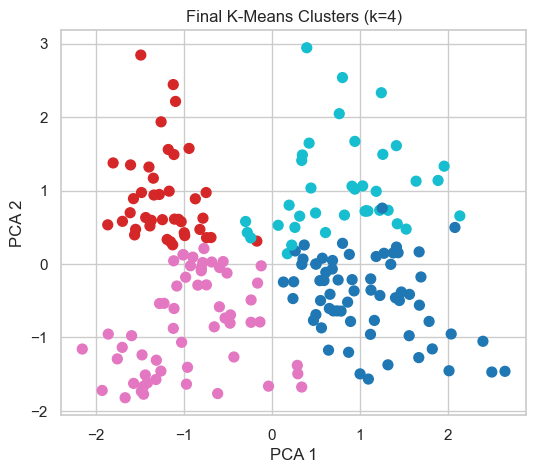

In [21]:
# PCA for final clusters
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap="tab10", s=50)
plt.title("Final K-Means Clusters (k=4)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


### Final Cluster Interpretation

Now that I’m looking at the final model with four clusters, the groups look clean and nicely separated. Each cluster seems to have its own area on the plot, and there isn’t much overlap, which tells me that the model is capturing real structure in the data. This matches everything we saw earlier with the elbow method and the silhouette score, so it feels like the right choice. From here, the next step is to understand what each cluster actually represents in terms of age, income and spending score, so I can describe the customer groups in a more meaningful way.


## 10. Cluster Profiles

To understand what each cluster actually represents, I calculated the average age, annual income and spending score for every group, together with the number of customers in each cluster. This turns the abstract cluster IDs into something closer to real customer segments.


In [23]:
# Cluster profiles: mean values for each feature inside each cluster
cluster_profile = df.groupby("Cluster")[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean().round(1)

# Also check how many customers we have in each cluster
cluster_counts = df["Cluster"].value_counts().sort_index()

cluster_profile["Count"] = cluster_counts
cluster_profile


,Age,Annual Income (k$),Spending Score (1-100),Count
Cluster,,,,
0,54.0,47.7,40.0,65
1,32.9,86.1,81.5,40
2,25.4,40.0,60.3,57
3,39.4,86.5,19.6,38


### Interpreting the Cluster Profiles

Looking at these averages, it becomes much easier to imagine who is in each group. One of the clusters has relatively young customers with high spending scores, which looks like a group of very active shoppers. Another cluster has customers with similar or even higher income but much lower spending scores, so they earn well but do not spend as aggressively in the mall. There is also at least one cluster with older customers and more moderate spending behavior. The exact numbers are not as important as the overall picture. The model is clearly separating people by a mix of age, income and how much they like to spend, which is exactly what we want from a customer segmentation model.


## 11. Visualizing Cluster Profiles (Barplots)

To get a clearer idea of how each cluster differs, I plotted the average age, income and spending score for all clusters. Barplots make it simple to compare the groups and see how they separate in terms of basic customer characteristics.


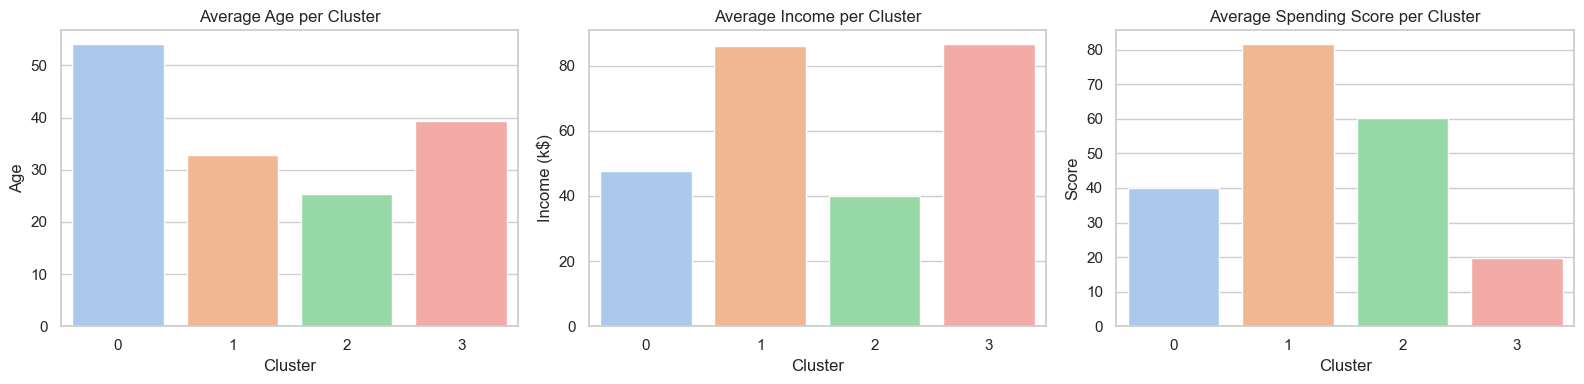

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure we use the same cluster_profile from earlier:
# cluster_profile = df.groupby("Cluster")[...]

plt.figure(figsize=(16, 4))

# Age
plt.subplot(1, 3, 1)
sns.barplot(data=cluster_profile.reset_index(), x="Cluster", y="Age", hue="Cluster", palette="pastel", legend=False)
plt.title("Average Age per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age")

# Income
plt.subplot(1, 3, 2)
sns.barplot(data=cluster_profile.reset_index(), x="Cluster", y="Annual Income (k$)", hue="Cluster", palette="pastel", legend=False)
plt.title("Average Income per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Income (k$)")

# Spending Score
plt.subplot(1, 3, 3)
sns.barplot(data=cluster_profile.reset_index(), x="Cluster", y="Spending Score (1-100)", hue="Cluster", palette="pastel", legend=False)
plt.title("Average Spending Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Score")

plt.tight_layout()
plt.show()



### Interpreting the Barplots

Looking at these barplots, I can already get a much clearer picture of how the clusters differ from each other. Some groups are obviously younger, some have much higher income, and one cluster stands out with a really high spending score. When I compare all three features side by side like this, it becomes easier to imagine what kind of customers each cluster might represent. Without even going too deep into statistics, I can already see personality types forming — a younger group that shops a lot, another group that earns well but barely spends, and a more moderate group that looks pretty balanced. It’s interesting how these simple averages start turning into real behavior patterns, and everything lines up nicely with what we saw earlier in the PCA plot and the cluste



### Cluster Summary

After looking at all the plots and the cluster profiles, I’m starting to see clear personalities forming inside these groups. One cluster looks like older customers who spend only occasionally, almost like steady visitors who come to the mall but don’t really shop much. Another group feels completely different — they’re young, active, and have a high spending score, which makes them look like the typical enthusiastic shoppers who enjoy buying things. There’s also a cluster with high income but surprisingly low spending, almost like people who have money but don’t really care about shopping. And one more group sits somewhere in the middle with moderate income and moderate spending, basically the balanced everyday customers. Seeing the numbers and plots come together like this makes the whole segmentation feel much more real, and it helps explain why the model picked these particular groups.


### Comparing k = 4, 5, and 6

When I compare the cluster results for k=4, k=5 and k=6, I start seeing a clear pattern. With k=4 the clusters feel clean and well separated, almost like each group found its own space without pushing into the others. When I switch to k=5, the boundaries become a little less natural and one or two of the clusters start looking like they were split without a strong reason. With k=6 the silhouette score was technically the highest, but visually the clusters sit very close to each other, and some of them look almost identical. It feels like the model is trying too hard to break the data into smaller pieces that don’t really add much meaning.

Because of that, k=4 ends up being the most balanced choice. It keeps the structure simple, the separation looks natural, and the clusters actually represent different types of customers instead of being forced divisions. Even though k=5 and k=6 are valid mathematically, they don’t give the same clean story that k=4 does, so choosing four clusters feels the most reasonable and practical.


## 12. Hierarchical Clustering

Since K-Means is only one way to see how the data naturally groups itself, I also wanted to explore another unsupervised method — hierarchical clustering. What I like about this approach is that it doesn’t make me choose the number of clusters from the start. Instead, it slowly builds a tree of connections and shows how points merge based on distance.

The dendrogram is usually the first step because it gives a visual sense of where the biggest jumps happen in the structure. Those jumps often hint at how many clusters make the most sense even before fitting an actual clustering model.


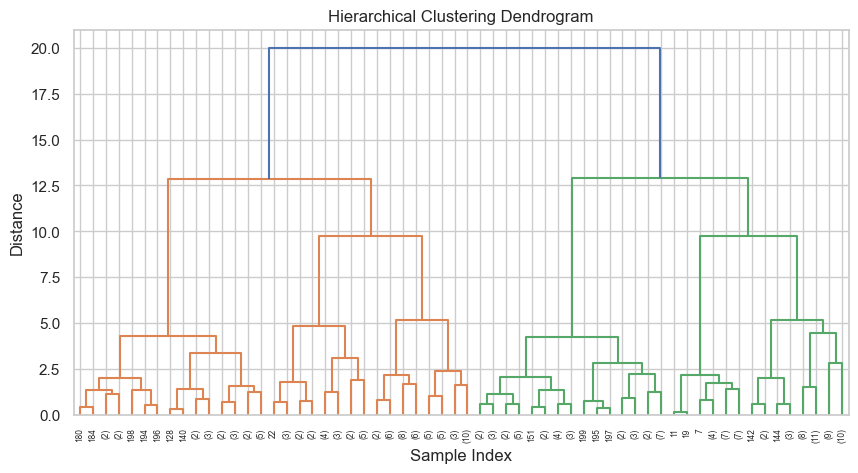

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Hierarchical clustering uses distances, so we use the scaled data
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked,
           truncate_mode='level',  # keeps the plot clean
           p=5,                   # show only the top clusters
           color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()
